---
title: Logistic Regression
subtitle: New Born Baby at Risk
date: 2025-03-24
from: markdown+emoji
execute: 
  eval: false
---

# Settings

In [ ]:
# Below is for an interactive display of Pandas DataFrame in Colab
from google.colab import data_table
data_table.enable_dataframe_formatter()

import pandas as pd
import numpy as np
from tabulate import tabulate  # for table summary
import scipy.stats as stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm  # for lowess smoothing
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

from pyspark.sql import SparkSession
from pyspark.sql.functions import rand, col, pow, mean, avg, when, log, sqrt, exp
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, GeneralizedLinearRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

spark = SparkSession.builder.master("local[*]").getOrCreate()

## UDFs

### add_dummy_variables

In [ ]:
#| code-fold: true
def add_dummy_variables(var_name, reference_level, category_order=None):
    """
    Creates dummy variables for the specified column in the global DataFrames dtrain and dtest.
    Allows manual setting of category order.

    Parameters:
        var_name (str): The name of the categorical column (e.g., "borough_name").
        reference_level (int): Index of the category to be used as the reference (dummy omitted).
        category_order (list, optional): List of categories in the desired order. If None, categories are sorted.

    Returns:
        dummy_cols (list): List of dummy column names excluding the reference category.
        ref_category (str): The category chosen as the reference.
    """
    global dtrain, dtest

    # Get distinct categories from the training set.
    categories = dtrain.select(var_name).distinct().rdd.flatMap(lambda x: x).collect()

    # Convert booleans to strings if present.
    categories = [str(c) if isinstance(c, bool) else c for c in categories]

    # Use manual category order if provided; otherwise, sort categories.
    if category_order:
        # Ensure all categories are present in the user-defined order
        missing = set(categories) - set(category_order)
        if missing:
            raise ValueError(f"These categories are missing from your custom order: {missing}")
        categories = category_order
    else:
        categories = sorted(categories)

    # Validate reference_level
    if reference_level < 0 or reference_level >= len(categories):
        raise ValueError(f"reference_level must be between 0 and {len(categories) - 1}")

    # Define the reference category
    ref_category = categories[reference_level]
    print("Reference category (dummy omitted):", ref_category)

    # Create dummy variables for all categories
    for cat in categories:
        dummy_col_name = var_name + "_" + str(cat).replace(" ", "_")
        dtrain = dtrain.withColumn(dummy_col_name, when(col(var_name) == cat, 1).otherwise(0))
        dtest = dtest.withColumn(dummy_col_name, when(col(var_name) == cat, 1).otherwise(0))

    # List of dummy columns, excluding the reference category
    dummy_cols = [var_name + "_" + str(cat).replace(" ", "_") for cat in categories if cat != ref_category]

    return dummy_cols, ref_category


# Example usage without category_order:
# dummy_cols_year, ref_category_year = add_dummy_variables('year', 0)

# Example usage with category_order:
# custom_order_wkday = ['sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday']
# dummy_cols_wkday, ref_category_wkday = add_dummy_variables('wkday', reference_level=0, category_order = custom_order_wkday)

### marginal_effects

In [ ]:
#| code-fold: true
def marginal_effects(model, means):
    """
    Compute marginal effects for all predictors in a PySpark GeneralizedLinearRegression model (logit)
    and return a formatted table with statistical significance and standard errors.

    Parameters:
        model: Fitted GeneralizedLinearRegression model (with binomial family and logit link).
        means: List of mean values for the predictor variables.

    Returns:
        - A formatted string containing the marginal effects table.
        - A Pandas DataFrame with marginal effects, standard errors, confidence intervals, and significance stars.
    """
    global assembler_predictors  # Use the global assembler_predictors list

    # Extract model coefficients, standard errors, and intercept
    coeffs = np.array(model.coefficients)
    std_errors = np.array(model.summary.coefficientStandardErrors)
    intercept = model.intercept

    # Compute linear combination of means and coefficients (XB)
    XB = np.dot(means, coeffs) + intercept

    # Compute derivative of logistic function (G'(XB))
    G_prime_XB = np.exp(XB) / ((1 + np.exp(XB)) ** 2)

    # Helper: significance stars.
    def significance_stars(p):
        if p < 0.01:
            return "***"
        elif p < 0.05:
            return "**"
        elif p < 0.1:
            return "*"
        else:
            return ""

    # Create lists to store results
    results = []
    df_results = []  # For Pandas DataFrame

    for i, predictor in enumerate(assembler_predictors):
        # Compute marginal effect
        marginal_effect = G_prime_XB * coeffs[i]

        # Compute standard error of the marginal effect
        std_error = G_prime_XB * std_errors[i]

        # Compute z-score and p-value
        z_score = marginal_effect / std_error if std_error != 0 else np.nan
        p_value = 2 * (1 - norm.cdf(abs(z_score))) if not np.isnan(z_score) else np.nan

        # Compute confidence interval (95%)
        ci_lower = marginal_effect - 1.96 * std_error
        ci_upper = marginal_effect + 1.96 * std_error

        # Append results for table formatting
        results.append([
            predictor,
            f"{marginal_effect: .6f}",
            significance_stars(p_value),
            f"{std_error: .6f}",
            f"{ci_lower: .6f}",
            f"{ci_upper: .6f}"
        ])

        # Append results for Pandas DataFrame
        df_results.append({
            "Variable": predictor,
            "Marginal Effect": marginal_effect,
            "Significance": significance_stars(p_value),
            "Std. Error": std_error,
            "95% CI Lower": ci_lower,
            "95% CI Upper": ci_upper
        })

    # Convert results to formatted table
    table_str = tabulate(results, headers=["Variable", "Marginal Effect", "Significance", "Std. Error", "95% CI Lower", "95% CI Upper"],
                         tablefmt="pretty", colalign=("left", "decimal", "left", "decimal", "decimal", "decimal"))

    # Convert results to Pandas DataFrame
    df_results = pd.DataFrame(df_results)

    return table_str, df_results

# Example usage:
# means = [0.5, 30]  # Mean values for x1 and x2
# assembler_predictors = ['x1', 'x2']  # Define globally before calling the function
# table_output, df_output = marginal_effects(fitted_model, means)
# print(table_output)
# display(df_output)

# Data Preparation

## Loading Data

In [ ]:
dfpd = pd.read_csv('https://bcdanl.github.io/data/NatalRiskData.csv')
df = spark.createDataFrame(dfpd)
dfpd

,PWGT,UPREVIS,CIG_REC,GESTREC3,DPLURAL,ULD_MECO,ULD_PRECIP,ULD_BREECH,URF_DIAB,URF_CHYPER,URF_PHYPER,URF_ECLAM,atRisk,DBWT,ORIGRANDGROUP
0,155,14,0,>= 37 weeks,single,1,0,0,0,0,0,0,0,3714,2
1,140,13,0,>= 37 weeks,single,0,0,0,0,0,0,0,0,3715,4
2,151,15,0,>= 37 weeks,single,0,0,0,0,0,0,0,0,3447,2
3,118,4,0,>= 37 weeks,single,0,0,0,0,0,0,0,0,3175,6
4,134,11,0,>= 37 weeks,single,0,0,0,0,0,0,0,0,4038,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26308,135,11,0,>= 37 weeks,single,0,0,0,0,0,0,0,0,3771,9
26309,135,12,0,>= 37 weeks,single,1,0,0,0,0,0,0,0,3210,8
26310,153,11,0,>= 37 weeks,single,0,0,0,0,0,0,0,0,3515,5
26311,132,10,0,>= 37 weeks,single,0,0,0,0,0,0,0,0,3147,9


## Training-Test Data Split

In [ ]:
dtrain, dtest = df.randomSplit([0.5, 0.5], seed = 1234)

## Adding Dummies

In [ ]:
dfpd['GESTREC3'].unique() # to see categories in GESTREC3 using the pandas' unique() method

array(['>= 37 weeks', '< 37 weeks'], dtype=object)

In [ ]:
dfpd['DPLURAL'].unique() # to see categories in DPLURAL

array(['single', 'twin', 'triplet or higher'], dtype=object)

In [ ]:
dummy_cols_GESTREC3, ref_category_GESTREC3 = add_dummy_variables('GESTREC3', 1)
dummy_cols_DPLURAL, ref_category_DPLURAL = add_dummy_variables('DPLURAL', 0)

Reference category (dummy omitted): >= 37 weeks
Reference category (dummy omitted): single


# Model

## Assembling Predictors

In [ ]:
# assembling predictors
x_cols = ['PWGT', 'UPREVIS', 'CIG_REC',
          'ULD_MECO', 'ULD_PRECIP', 'ULD_BREECH', 'URF_DIAB',
          'URF_CHYPER', 'URF_PHYPER', 'URF_ECLAM']

# Keep the name assembler_predictors unchanged,
#   as it will be used as a global variable in the marginal_effects UDF.
assembler_predictors = (
    x_cols +
    dummy_cols_GESTREC3 + dummy_cols_DPLURAL
)

assembler_1 = VectorAssembler(
    inputCols = assembler_predictors,
    outputCol = "predictors"
)

dtrain_1 = assembler_1.transform(dtrain)
dtest_1  = assembler_1.transform(dtest)

## Model Fitting


In [ ]:
# training the model
model_1 = (
    GeneralizedLinearRegression(featuresCol="predictors",
                                labelCol="atRisk",
                                family="binomial",
                                link="logit")
    .fit(dtrain_1)
)

## Making Predictions

In [ ]:
# making prediction on both training and test
dtrain_1 = model_1.transform(dtrain_1)
dtest_1 = model_1.transform(dtest_1)

## Model Summary

In [ ]:
model_1.summary

Coefficients:
             Feature Estimate Std Error  T Value P Value
         (Intercept)  -4.7385    0.3154 -15.0256  0.0000
                PWGT   0.0029    0.0016   1.8572  0.0633
             UPREVIS  -0.0285    0.0164  -1.7352  0.0827
             CIG_REC   0.3991    0.1965   2.0306  0.0423
            ULD_MECO   1.0701    0.2330   4.5921  0.0000
          ULD_PRECIP   0.4391    0.3564   1.2318  0.2180
          ULD_BREECH   0.3139    0.2193   1.4312  0.1524
            URF_DIAB  -0.0954    0.2874  -0.3320  0.7399
          URF_CHYPER   0.2442    0.4772   0.5117  0.6089
          URF_PHYPER   0.1417    0.2728   0.5196  0.6033
           URF_ECLAM   0.7946    0.7677   1.0350  0.3006
 GESTREC3_<_37_weeks   1.5390    0.1524  10.0977  0.0000
DPLURAL_triplet_o...   1.5956    0.5906   2.7016  0.0069
        DPLURAL_twin   0.5490    0.2400   2.2877  0.0222

(Dispersion parameter for binomial family taken to be 1.0000)
    Null deviance: 2332.2568 on 13108 degrees of freedom
Residual de

## Marginal Effects

### Calculating the Mean Value of Each Predictor

In [ ]:
# Compute means
means_df = dtrain_1.select([mean(col).alias(col) for col in assembler_predictors])

# Collect the results as a list
means = means_df.collect()[0]
means_list = [means[col] for col in assembler_predictors]

In [ ]:
table_output, df_ME = marginal_effects(model_1, means_list) # Instead of mean values, some other representative values can also be chosen.
print(table_output)

+---------------------------+-----------------+--------------+------------+--------------+--------------+
| Variable                  | Marginal Effect | Significance | Std. Error | 95% CI Lower | 95% CI Upper |
+---------------------------+-----------------+--------------+------------+--------------+--------------+
| PWGT                      |          0.0000 | *            |     0.0000 |      -0.0000 |       0.0001 |
| UPREVIS                   |         -0.0004 | *            |     0.0002 |      -0.0008 |       0.0000 |
| CIG_REC                   |          0.0053 | **           |     0.0026 |       0.0002 |       0.0104 |
| ULD_MECO                  |          0.0142 | ***          |     0.0031 |       0.0082 |       0.0203 |
| ULD_PRECIP                |          0.0058 |              |     0.0047 |      -0.0035 |       0.0151 |
| ULD_BREECH                |          0.0042 |              |     0.0029 |      -0.0015 |       0.0099 |
| URF_DIAB                  |         -0.0013 

### Marginal Effect Plot

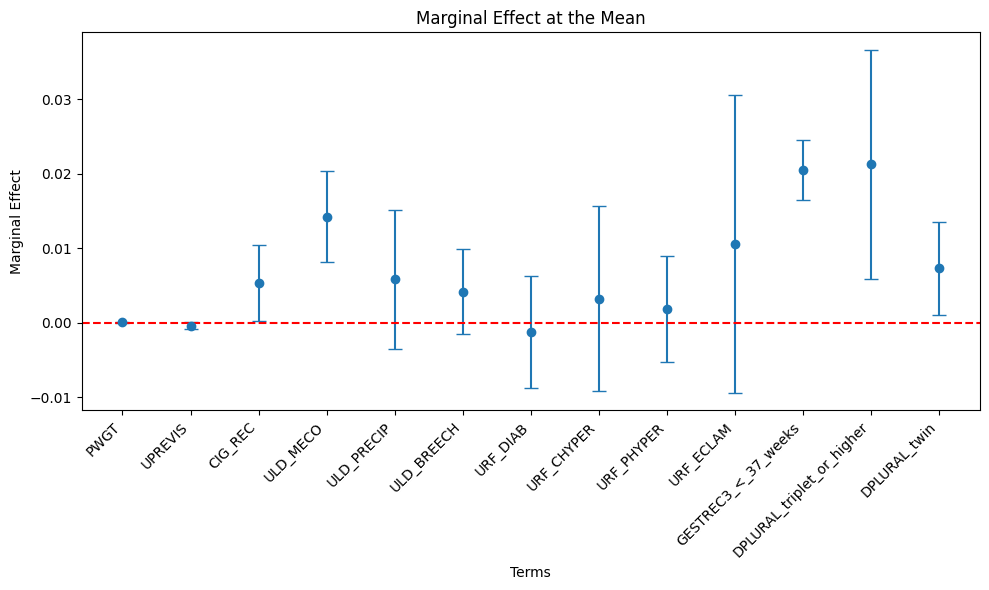

In [ ]:
# Increase figure size to prevent overlapping
plt.figure(figsize=(10, 6))

# Plot using the DataFrame columns
plt.errorbar(df_ME["Variable"], df_ME["Marginal Effect"],
             yerr=1.96 * df_ME["Std. Error"], fmt='o', capsize=5)

# Labels and title
plt.xlabel("Terms")
plt.ylabel("Marginal Effect")
plt.title("Marginal Effect at the Mean")

# Add horizontal line at 0 for reference
plt.axhline(0, color="red", linestyle="--")

# Adjust x-axis labels to avoid overlap
plt.xticks(rotation=45, ha="right")  # Rotate and align labels to the right
plt.tight_layout()  # Adjust layout to prevent overlap

# Show plot
plt.show()

In [ ]:
# Compute means for smokers
means_df_smoker = (
    dtrain_1
    .filter(
        ( col("CIG_REC") == 1 )
    )
    .select([mean(col).alias(col) for col in assembler_predictors])
)

# Collect the results as a list
means_smoker = means_df_smoker.collect()[0]
means_list_smoker = [means_smoker[col] for col in assembler_predictors]

In [ ]:
table_output_s, df_ME_s = marginal_effects(model_1, means_list_smoker) # Instead of mean values, some other representative values can also be chosen.
print(table_output_s)

+---------------------------+-----------------+--------------+------------+--------------+--------------+
| Variable                  | Marginal Effect | Significance | Std. Error | 95% CI Lower | 95% CI Upper |
+---------------------------+-----------------+--------------+------------+--------------+--------------+
| PWGT                      |          0.0001 | *            |     0.0000 |      -0.0000 |       0.0001 |
| UPREVIS                   |         -0.0006 | *            |     0.0003 |      -0.0012 |       0.0001 |
| CIG_REC                   |          0.0081 | **           |     0.0040 |       0.0003 |       0.0160 |
| ULD_MECO                  |          0.0218 | ***          |     0.0047 |       0.0125 |       0.0311 |
| ULD_PRECIP                |          0.0089 |              |     0.0073 |      -0.0053 |       0.0232 |
| ULD_BREECH                |          0.0064 |              |     0.0045 |      -0.0024 |       0.0152 |
| URF_DIAB                  |         -0.0019 

# Classification

## Classifier Threshold - Double Density Plot

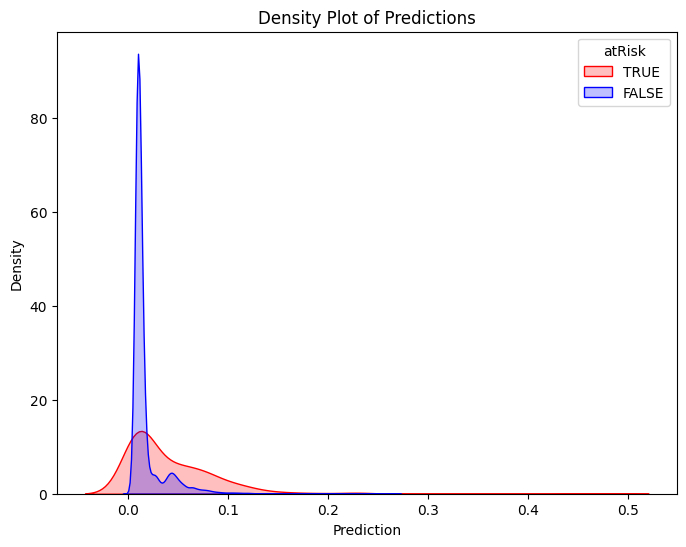

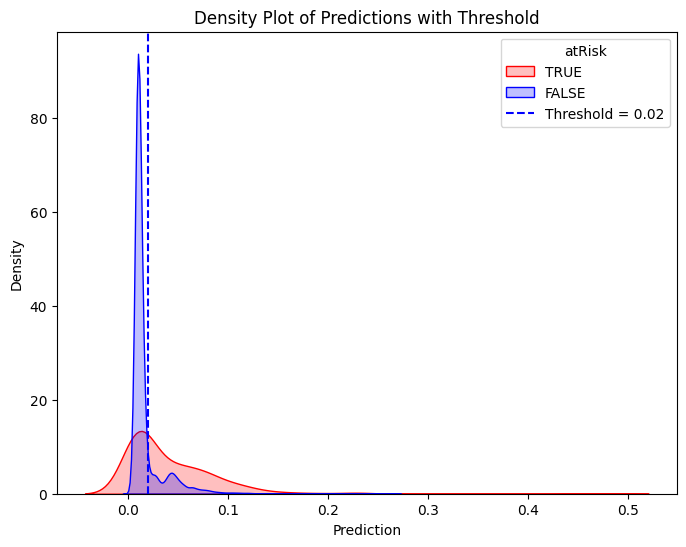

In [ ]:
# Filter training data for atRisk == 1 and atRisk == 0
pdf = dtrain_1.select("prediction", "atRisk").toPandas()

train_true = pdf[pdf["atRisk"] == 1]
train_false = pdf[pdf["atRisk"] == 0]

# Create the first density plot
plt.figure(figsize=(8, 6))
sns.kdeplot(train_true["prediction"], label="TRUE", color="red", fill=True)
sns.kdeplot(train_false["prediction"], label="FALSE", color="blue", fill=True)
plt.xlabel("Prediction")
plt.ylabel("Density")
plt.title("Density Plot of Predictions")
plt.legend(title="atRisk")
plt.show()

# Define threshold for vertical line
threshold = 0.02  # Replace with actual value

# Create the second density plot with vertical line
plt.figure(figsize=(8, 6))
sns.kdeplot(train_true["prediction"], label="TRUE", color="red", fill=True)
sns.kdeplot(train_false["prediction"], label="FALSE", color="blue", fill=True)
plt.axvline(x=threshold, color="blue", linestyle="dashed", label=f"Threshold = {threshold}")
plt.xlabel("Prediction")
plt.ylabel("Density")
plt.title("Density Plot of Predictions with Threshold")
plt.legend(title="atRisk")
plt.show()

## Performance of Classifier

### Confusion Matrix & Performance Metrics

In [ ]:
# Compute confusion matrix
dtest_1 = dtest_1.withColumn("predicted_class", when(col("prediction") > .02, 1).otherwise(0))
conf_matrix = dtest_1.groupBy("atRisk", "predicted_class").count().orderBy("atRisk", "predicted_class")

TP = dtest_1.filter((col("atRisk") == 1) & (col("predicted_class") == 1)).count()
FP = dtest_1.filter((col("atRisk") == 0) & (col("predicted_class") == 1)).count()
FN = dtest_1.filter((col("atRisk") == 1) & (col("predicted_class") == 0)).count()
TN = dtest_1.filter((col("atRisk") == 0) & (col("predicted_class") == 0)).count()

accuracy = (TP + TN) / (TP + FP + FN + TN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
specificity = TN / (TN + FP)
average_rate = (TP + FN) / (TP + TN + FP + FN)  # Proportion of actual at-risk babies
enrichment = precision / average_rate


# Print formatted confusion matrix with labels
print("\n Confusion Matrix:\n")
print("                     Predicted")
print("            |  Negative  |  Positive  ")
print("------------+------------+------------")
print(f"Actual Neg. |    {TN:5}   |    {FP:5}  |")
print("------------+------------+------------")
print(f"Actual Pos. |    {FN:5}   |    {TP:5}  |")
print("------------+------------+------------")


print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity:  {specificity:.4f}")
print(f"Average Rate: {average_rate:.4f}")
print(f"Enrichment:   {enrichment:.4f} (Relative Precision)")



 Confusion Matrix:

                     Predicted
            |  Negative  |  Positive  
------------+------------+------------
Actual Neg. |    10774   |     2167  |
------------+------------+------------
Actual Pos. |      120   |      130  |
------------+------------+------------
Accuracy:  0.8266
Precision: 0.0566
Recall (Sensitivity): 0.5200
Specificity:  0.8325
Average Rate: 0.0190
Enrichment:   2.9862 (Relative Precision)


### Trade-off Between Recall and Precision/Enrichment

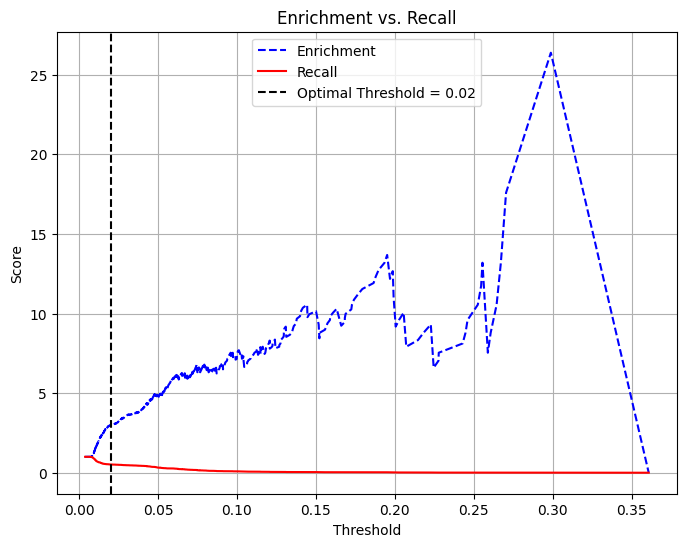

In [ ]:
pdf = dtest_1.select("prediction", "atRisk").toPandas()

# Extract predictions and true labels
y_true = pdf["atRisk"]  # True labels
y_scores = pdf["prediction"]  # Predicted probabilities

# Compute precision, recall, and thresholds
precision_plot, recall_plot, thresholds = precision_recall_curve(y_true, y_scores)

# Compute enrichment: precision divided by average at-risk rate
average_rate = np.mean(y_true)
enrichment_plot = precision_plot / average_rate

# Define optimal threshold (example: threshold where recall ≈ enrichment balance)
threshold = 0.02  # Adjust based on the plot

# Plot Enrichment vs. Recall vs. Threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds, enrichment_plot[:-1], label="Enrichment", color="blue", linestyle="--")
plt.plot(thresholds, recall_plot[:-1], label="Recall", color="red", linestyle="-")

# Add vertical line for chosen threshold
plt.axvline(x=threshold, color="black", linestyle="dashed", label=f"Threshold = {threshold}")

# Labels and legend
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Enrichment vs. Recall")
plt.legend()
plt.grid(True)
plt.show()

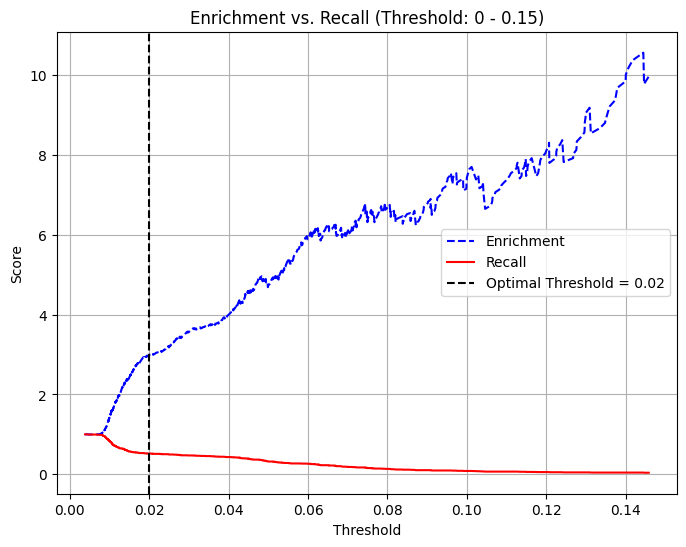

In [ ]:
# Filter the threshold range (0 to 0.15)
mask = (thresholds >= 0) & (thresholds <= 0.15)
thresholds_filtered = thresholds[mask]
enrichment_filtered = enrichment[:-1][mask]
recall_filtered = recall[:-1][mask]

# Define optimal threshold (example: threshold where recall ≈ enrichment balance)
threshold = 0.02  # Adjust based on the plot

# Plot Enrichment vs. Recall vs. Threshold (Limited to 0 - 0.15)
plt.figure(figsize=(8, 6))
plt.plot(thresholds_filtered, enrichment_filtered, label="Enrichment", color="blue", linestyle="--")
plt.plot(thresholds_filtered, recall_filtered, label="Recall", color="red", linestyle="-")

# Add vertical line for chosen threshold
plt.axvline(x=threshold, color="black", linestyle="dashed", label=f"Threshold = {threshold}")

# Labels and legend
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Enrichment vs. Recall (Threshold: 0 - 0.15)")
plt.legend()
plt.grid(True)
plt.show()

### AUC and ROC

AUC: 0.7310


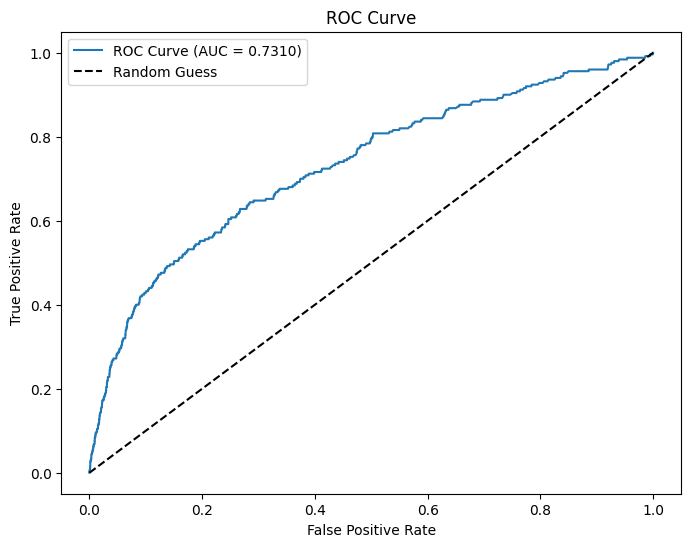

In [ ]:
# Use probability of the positive class (y=1)
evaluator = BinaryClassificationEvaluator(labelCol="atRisk", rawPredictionCol="prediction", metricName="areaUnderROC")

# Evaluate AUC
auc = evaluator.evaluate(dtest_1)

print(f"AUC: {auc:.4f}")  # Higher is better (closer to 1)

# Convert to Pandas
pdf = dtest_1.select("prediction", "atRisk").toPandas()

# Compute ROC curve
fpr, tpr, _ = roc_curve(pdf["atRisk"], pdf["prediction"])

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

## Deploying the Classifier to the Real-World

### Real-world Data for NY and MA Hospitals

In [ ]:
pd_dtest = dtest.toPandas()

# Set seed for reproducibility
np.random.seed(23464)

# Sample 1000 random indices from the test dataset without replacement
sample_indices = np.random.choice(pd_dtest.index, size=1000, replace=False)

# Separate the selected observations from testing data
separated = pd_dtest.loc[sample_indices]

# Remove the selected observations from the testing data
# Consider this as data from NY hospitals
pd_dtest_NY = pd_dtest.drop(sample_indices)

# Split the separated sample into at-risk and not-at-risk groups
at_risk_sample = separated[separated["atRisk"] == 1]  # Only at-risk cases
not_at_risk_sample = separated[separated["atRisk"] == 0]  # Only not-at-risk cases

# Create test sets for MA hospitals with different at-risk average rates compared to NY
pd_dtest_MA_moreRisk = pd.concat([pd_dtest_NY, at_risk_sample])  # Adds back only at-risk cases
pd_dtest_MA_lessRisk = pd.concat([pd_dtest_NY, not_at_risk_sample])  # Adds back only not-at-risk cases

# Show counts to verify results
print("Original Test Set Size:", pd_dtest.shape[0])
print("Sampled Separated Size:", separated.shape[0])
print("NY Hospitals Data Size:", pd_dtest_NY.shape[0])
print("MA More Risk Data Size:", pd_dtest_MA_moreRisk.shape[0])
print("MA Less Risk Data Size:", pd_dtest_MA_lessRisk.shape[0])

dtest_MA_moreRisk = spark.createDataFrame(pd_dtest_MA_moreRisk)
dtest_MA_lessRisk = spark.createDataFrame(pd_dtest_MA_lessRisk)

Original Test Set Size: 13191
Sampled Separated Size: 1000
NY Hospitals Data Size: 12191
MA More Risk Data Size: 12217
MA Less Risk Data Size: 13165


### MA with more at-risk babies



In [ ]:
dtest_MA_moreRisk = assembler_1.transform(dtest_MA_moreRisk)
dtest_MA_moreRisk = model_1.transform(dtest_MA_moreRisk)

# Compute confusion matrix
dtest_MA_moreRisk = dtest_MA_moreRisk.withColumn("predicted_class", when(col("prediction") > .02, 1).otherwise(0))
conf_matrix_MA_moreRisk = dtest_MA_moreRisk.groupBy("atRisk", "predicted_class").count().orderBy("atRisk", "predicted_class")

# Collect as a dictionary for easy lookup
conf_dict_MA_moreRisk = {(row["atRisk"], row["predicted_class"]): row["count"] for row in conf_matrix_MA_moreRisk.collect()}

# Extract values safely (handle missing values if any)
TN = conf_dict_MA_moreRisk.get((0, 0), 0)  # True Negative
FP = conf_dict_MA_moreRisk.get((0, 1), 0)  # False Positive
FN = conf_dict_MA_moreRisk.get((1, 0), 0)  # False Negative
TP = conf_dict_MA_moreRisk.get((1, 1), 0)  # True Positive

accuracy_moreRisk = (TP + TN) / (TP + FP + FN + TN)
precision_moreRisk = TP / (TP + FP)
recall_moreRisk = TP / (TP + FN) # (Recall) + (False Negative Rate) = 1
specificity_moreRisk = TN / (TN + FP) # (Specificity) + (False Positive Rate) = 1
average_rate_moreRisk = (TP + FN) / (TP + TN + FP + FN)  # Proportion of actual at-risk babies
enrichment_moreRisk = precision_moreRisk / average_rate_moreRisk

# Print formatted confusion matrix with labels
print("\n Confusion Matrix with More At-Risk Babies in MA:\n")
print("                     Predicted")
print("            |  Negative  |  Positive  ")
print("------------+------------+------------")
print(f"Actual Neg. |    {TN:5}   |    {FP:5}  |")
print("------------+------------+------------")
print(f"Actual Pos. |    {FN:5}   |    {TP:5}  |")
print("------------+------------+------------")

print(f"Accuracy:             {accuracy_moreRisk:.4f}")
print(f"Precision:            {precision_moreRisk:.4f}")
print(f"Recall (Sensitivity): {recall_moreRisk:.4f}")
print(f"Specificity:          {specificity_moreRisk:.4f}")
print(f"Average Rate:         {average_rate_moreRisk:.4f}")  # Proportion of actual at-risk babies
print(f"Enrichment:           {enrichment_moreRisk:.4f} (Relative Precision)")

# Evaluate AUC
auc_moreRisk = evaluator.evaluate(dtest_MA_moreRisk)

print(f"AUC: {auc_moreRisk:.4f}")  # Higher is better (closer to 1)


 Confusion Matrix with More At-Risk Babies in MA:

                     Predicted
            |  Negative  |  Positive  
------------+------------+------------
Actual Neg. |     9965   |     2002  |
------------+------------+------------
Actual Pos. |      120   |      130  |
------------+------------+------------
Accuracy:             0.8263
Precision:            0.0610
Recall (Sensitivity): 0.5200
Specificity:          0.8327
Average Rate:         0.0205
Enrichment:           2.9798 (Relative Precision)
AUC: 0.7307


### MA with less at-risk babies


In [ ]:
dtest_MA_lessRisk = assembler_1.transform(dtest_MA_lessRisk)
dtest_MA_lessRisk = model_1.transform(dtest_MA_lessRisk)

# Compute confusion matrix
dtest_MA_lessRisk = dtest_MA_lessRisk.withColumn("predicted_class", when(col("prediction") > .02, 1).otherwise(0))
conf_matrix_MA_lessRisk = dtest_MA_lessRisk.groupBy("atRisk", "predicted_class").count().orderBy("atRisk", "predicted_class")

# Collect as a dictionary for easy lookup
conf_dict_MA_lessRisk = {(row["atRisk"], row["predicted_class"]): row["count"] for row in conf_matrix_MA_lessRisk.collect()}

# Extract values safely (handle missing values if any)
TN = conf_dict_MA_lessRisk.get((0, 0), 0)  # True Negative
FP = conf_dict_MA_lessRisk.get((0, 1), 0)  # False Positive
FN = conf_dict_MA_lessRisk.get((1, 0), 0)  # False Negative
TP = conf_dict_MA_lessRisk.get((1, 1), 0)  # True Positive

accuracy_lessRisk = (TP + TN) / (TP + FP + FN + TN)
precision_lessRisk = TP / (TP + FP)
recall_lessRisk = TP / (TP + FN) # (Recall) + (False Negative Rate) = 1
specificity_lessRisk = TN / (TN + FP) # (Specificity) + (False Positive Rate) = 1
average_rate_lessRisk = (TP + FN) / (TP + TN + FP + FN)  # Proportion of actual at-risk babies
enrichment_lessRisk = precision_lessRisk / average_rate_lessRisk

# Print formatted confusion matrix with labels
print("\n Confusion Matrix with Less At-Risk Babies in MA:\n")
print("                     Predicted")
print("            |  Negative  |  Positive  ")
print("------------+------------+------------")
print(f"Actual Neg. |    {TN:5}   |    {FP:5}  |")
print("------------+------------+------------")
print(f"Actual Pos. |    {FN:5}   |    {TP:5}  |")
print("------------+------------+------------")

print(f"Accuracy:             {accuracy_lessRisk:.4f}")
print(f"Precision:            {precision_lessRisk:.4f}")
print(f"Recall (Sensitivity): {recall_lessRisk:.4f}")
print(f"Specificity:          {specificity_lessRisk:.4f}")
print(f"Average Rate:         {average_rate_lessRisk:.4f}")  # Proportion of actual at-risk babies
print(f"Enrichment:           {enrichment_lessRisk:.4f} (Relative Precision)")

# Evaluate AUC
auc_lessRisk = evaluator.evaluate(dtest_MA_lessRisk)

print(f"AUC: {auc_lessRisk:.4f}")  # Higher is better (closer to 1)


 Confusion Matrix with Less At-Risk Babies in MA:

                     Predicted
            |  Negative  |  Positive  
------------+------------+------------
Actual Neg. |    10774   |     2167  |
------------+------------+------------
Actual Pos. |      106   |      118  |
------------+------------+------------
Accuracy:             0.8273
Precision:            0.0516
Recall (Sensitivity): 0.5268
Specificity:          0.8325
Average Rate:         0.0170
Enrichment:           3.0351 (Relative Precision)
AUC: 0.7316


### Performance Comparison

In [ ]:
# Define baseline, more risk, and less risk metrics
baseline_metrics = {
    "Average Rate": average_rate,
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall (Sensitivity)": recall,
    "False Negative Rate": 1 - recall,
    "Specificity": specificity,
    "False Positive Rate": 1 - specificity,
    "Enrichment": enrichment,
    "AUC": auc
}

more_risk_metrics = {
    "Average Rate": average_rate_moreRisk,
    "Accuracy": accuracy_moreRisk,
    "Precision": precision_moreRisk,
    "Recall (Sensitivity)": recall_moreRisk,
    "False Negative Rate": 1 - recall_moreRisk,
    "Specificity": specificity_moreRisk,
    "False Positive Rate": 1 - specificity_moreRisk,
    "Enrichment": enrichment_moreRisk,
    "AUC": auc_moreRisk
}

less_risk_metrics = {
    "Average Rate": average_rate_lessRisk,
    "Accuracy": accuracy_lessRisk,
    "Precision": precision_lessRisk,
    "Recall (Sensitivity)": recall_lessRisk,
    "False Negative Rate": 1 - recall_lessRisk,
    "Specificity": specificity_lessRisk,
    "False Positive Rate": 1 - specificity_lessRisk,
    "Enrichment": enrichment_lessRisk,
    "AUC": auc_lessRisk
}

# Compute percentage change for each scenario
percentage_change = {
    "More At-Risk": [],
    "Less At-Risk": []
}

for metric in baseline_metrics.keys():
    percentage_change["More At-Risk"].append(more_risk_metrics[metric])
    percentage_change["Less At-Risk"].append(less_risk_metrics[metric])

# Create a DataFrame including baseline metrics with rounded NY values
df_metrics = pd.DataFrame({
    "Metric": list(baseline_metrics.keys()),
    "NY": [round(value, 4) for value in baseline_metrics.values()],  # Round US values
    "MA with More At-Risk": [
        round(more_risk_metrics[metric], 4)
        for metric in baseline_metrics.keys()
    ],
    "MA with Less At-Risk": [
        round(less_risk_metrics[metric], 4)
        for metric in baseline_metrics.keys()
    ]
})

# Print formatted table
print(tabulate(df_metrics, headers="keys", tablefmt="pretty", showindex=False, colalign=("left", "decimal", "decimal")))

+----------------------+--------+----------------------+----------------------+
| Metric               |     NY | MA with More At-Risk | MA with Less At-Risk |
+----------------------+--------+----------------------+----------------------+
| Average Rate         | 0.019  |               0.0205 |        0.017         |
| Accuracy             | 0.8266 |               0.8263 |        0.8273        |
| Precision            | 0.0566 |               0.061  |        0.0516        |
| Recall (Sensitivity) | 0.52   |               0.52   |        0.5268        |
| False Negative Rate  | 0.48   |               0.48   |        0.4732        |
| Specificity          | 0.8325 |               0.8327 |        0.8325        |
| False Positive Rate  | 0.1675 |               0.1673 |        0.1675        |
| Enrichment           | 2.9862 |               2.9798 |        3.0351        |
| AUC                  | 0.731  |               0.7307 |        0.7316        |
+----------------------+--------+-------

In [ ]:
# Define baseline, more risk, and less risk metrics
baseline_metrics = {
    "Average Rate": average_rate,
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall (Sensitivity)": recall,
    "False Negative Rate": 1 - recall,
    "Specificity": specificity,
    "False Positive Rate": 1 - specificity,
    "Enrichment": enrichment,
    "AUC": auc
}

more_risk_metrics = {
    "Average Rate": average_rate_moreRisk,
    "Accuracy": accuracy_moreRisk,
    "Precision": precision_moreRisk,
    "Recall (Sensitivity)": recall_moreRisk,
    "False Negative Rate": 1 - recall_moreRisk,
    "Specificity": specificity_moreRisk,
    "False Positive Rate": 1 - specificity_moreRisk,
    "Enrichment": enrichment_moreRisk,
    "AUC": auc_moreRisk
}

less_risk_metrics = {
    "Average Rate": average_rate_lessRisk,
    "Accuracy": accuracy_lessRisk,
    "Precision": precision_lessRisk,
    "Recall (Sensitivity)": recall_lessRisk,
    "False Negative Rate": 1 - recall_lessRisk,
    "Specificity": specificity_lessRisk,
    "False Positive Rate": 1 - specificity_lessRisk,
    "Enrichment": enrichment_lessRisk,
    "AUC": auc_lessRisk
}

# Compute percentage change for each scenario
percentage_change = {
    "More At-Risk (%)": [],
    "Less At-Risk (%)": []
}

for metric in baseline_metrics.keys():
    percentage_change["More At-Risk (%)"].append(round(((more_risk_metrics[metric] - baseline_metrics[metric]) / baseline_metrics[metric]) * 100, 2))
    percentage_change["Less At-Risk (%)"].append(round(((less_risk_metrics[metric] - baseline_metrics[metric]) / baseline_metrics[metric]) * 100, 2))

# Create a DataFrame including baseline metrics with rounded NY values
df_metrics = pd.DataFrame({
    "Metric": list(baseline_metrics.keys()),
    "NY": [round(value, 2) for value in baseline_metrics.values()],  # Round US values
    "MA with More At-Risk (%)": [
        round(((more_risk_metrics[metric] - baseline_metrics[metric]) / baseline_metrics[metric]) * 100, 2)
        for metric in baseline_metrics.keys()
    ],
    "MA with Less At-Risk (%)": [
        round(((less_risk_metrics[metric] - baseline_metrics[metric]) / baseline_metrics[metric]) * 100, 2)
        for metric in baseline_metrics.keys()
    ]
})

# Print formatted table
print(tabulate(df_metrics, headers="keys", tablefmt="pretty", showindex=False, colalign=("left", "decimal", "decimal")))

+----------------------+------+--------------------------+--------------------------+
| Metric               |   NY | MA with More At-Risk (%) | MA with Less At-Risk (%) |
+----------------------+------+--------------------------+--------------------------+
| Average Rate         | 0.02 |                     7.97 |          -10.22          |
| Accuracy             | 0.83 |                    -0.04 |           0.09           |
| Precision            | 0.06 |                     7.74 |          -8.75           |
| Recall (Sensitivity) | 0.52 |                     0.0  |           1.3            |
| False Negative Rate  | 0.48 |                     0.0  |          -1.41           |
| Specificity          | 0.83 |                     0.02 |           0.0            |
| False Positive Rate  | 0.17 |                    -0.09 |           0.0            |
| Enrichment           | 2.99 |                    -0.22 |           1.64           |
| AUC                  | 0.73 |                    -0.